In [1]:
! git clone 'https://github.com/PeterF1234/DFT-ML-excited-state-redox/' # if using Google Colab

Cloning into 'DFT-ML-excited-state-redox'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 37 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (37/37), 3.21 MiB | 2.63 MiB/s, done.


## Import libraries

In [1]:
# !pip install matplotlib --upgrade # 1) uncomment, 2) run, 3) restart kernel, 4) comment out, 5) run all

In [2]:
import matplotlib as matp
matp.__version__ # correlation plots require 3.5+

'3.7.1'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

In [4]:
pd.__version__

'1.3.5'

## Plot some literature data

First we use the [review paper of Nicewicz et al.](https://doi.org/10.1021/acs.chemrev.6b00057) to plot the accuracy of the absorption approximation for E<sub>0,0</sub> based on experimental organic photocatalyst data:

<ipython-input-5-69e282da70fb>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


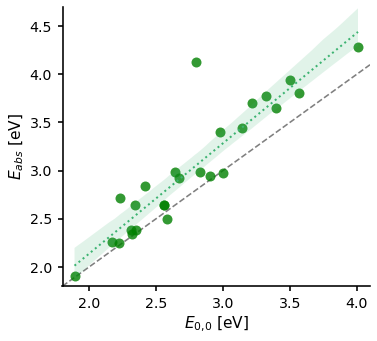

In [5]:
approx_e00 = pd.read_csv("/content/DFT-ML-excited-state-redox/E00_data/lambda_max_vs_E00.csv", sep=';', header=0)

sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.lmplot(data=approx_e00, x="E00 (eV)", y="lambda_max (eV)", aspect=1.1,
               scatter_kws={"s": 100,"color":"green"}, line_kws={"lw": 2,"ls": ":","color":"mediumseagreen"})
g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{0,\!0}$ [eV]'),ylabel=(r'$E_{abs}$ [eV]'))

sns.despine()
plt.xlim(1.8,4.1)
plt.ylim(1.8,4.7)
plt.tight_layout()
# plt.savefig('lambda_max_vs_E00_Nicewicz.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [6]:
approx_e00["diff"] = abs(approx_e00["lambda_max (eV)"] - approx_e00["E00 (eV)"])
meanDiff = approx_e00["diff"].mean().round(2)
print(f"MAE with the outlier: {meanDiff} eV")
meanDiff = approx_e00.query("diff < 1.3")["diff"].mean().round(2)
print(f"MAE without the outlier: {meanDiff} eV")

MAE with the outlier: 0.26 eV
MAE without the outlier: 0.22 eV


We can also use the more extensive [Deep4Chem dataset from Park et al.](https://doi.org/10.1038/s41597-020-00634-8) to plot accuracy of the absorption approximation for E<sub>0,0</sub> based on experimental organic photocatalyst data.

In [7]:
deep4chem_db = pd.read_csv("/content/DFT-ML-excited-state-redox/DB for chromophore_Sci_Data_rev02.csv")

- we only use data for solvents acetonitrile, dichloromethane and DMF as they are the solvents present in our dataset 
- E<sub>0,0</sub> is not included directly, so we take the average of the absorption and emission energies

> **Note:** Best practice is to [use energy scale](https://mattermodeling.stackexchange.com/questions/9345/vertical-transition-0-0-transition-and-experimental-spectra) when calculating the mean. Using the average of wavelengths yields slightly different MAE (0.31 eV) due to the non-linear relationship between wavelength and energy.

In [8]:
deep4chem_data = deep4chem_db.query("Solvent in ['CC#N','ClCCl','CN(C)C=O']").get(["Absorption max (nm)","Emission max (nm)"]).copy()
# convert to eV, then calculate the average
deep4chem_data["E_00"] = ((1240. / deep4chem_data["Absorption max (nm)"]) + (1240. / deep4chem_data["Emission max (nm)"])) / 2
# converting the average of wavelengths yields slightly different results
# deep4chem_data["E_00"] = 1240. / ((deep4chem_data["Absorption max (nm)"] + deep4chem_data["Emission max (nm)"]) / 2)
deep4chem_data["E_abs"] = 1240. / deep4chem_data["Absorption max (nm)"]
deep4chem_data = deep4chem_data.get(["E_abs","E_00"]).dropna().reset_index(drop=True).copy()

<ipython-input-9-d8d627de23d3>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


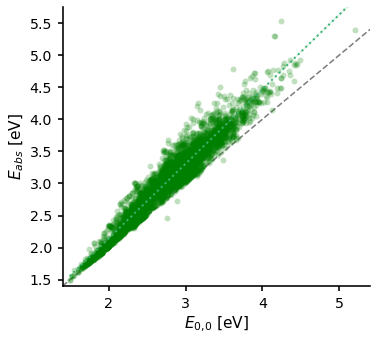

In [9]:
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.lmplot(data=deep4chem_data, x="E_00", y="E_abs", aspect=1.1,
               scatter_kws={"s": 35,"color":"green","alpha":0.25}, line_kws={"lw": 2,"ls": ":","color":"mediumseagreen"})
g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{0,\!0}$ [eV]'),ylabel=(r'$E_{abs}$ [eV]'))

sns.despine()
plt.xlim(1.4,5.4)
plt.ylim(1.4,5.75)
plt.tight_layout()
# plt.savefig('lambda_max_vs_E00_deep4chem.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

In [10]:
deep4chem_data["diff"] = abs(deep4chem_data["E_abs"] - deep4chem_data["E_00"])
meanDiff = deep4chem_data["diff"].mean().round(2)
print(f"MAE for the Deep4Chem dataset: {meanDiff} eV")

MAE for the Deep4Chem dataset: 0.27 eV


> **Note:** We get very similar values for MAE and also a similar trend can be observed where the difference between E<sub>0,0</sub> and E<sub>abs</sub> increases as E<sub>0,0</sub> increases. This is indicated by the deviation of the `mediumseagreen` dotted trend line from the x=y line on the plots.

In [11]:
deep4chem_data_b = deep4chem_data.query("E_00 > 1.3 and E_00 < 3.5").copy()
deep4chem_data_b["diff"] = abs(deep4chem_data_b["E_abs"] - deep4chem_data_b["E_00"])
meanDiff = deep4chem_data_b["diff"].mean().round(2)
print(f"MAE for the Deep4Chem dataset: {meanDiff} eV")

MAE for the Deep4Chem dataset: 0.27 eV


The MAE is the same (within two decimals) if we only consider E<sub>0,0</sub> in the visible (with some extension: 350-950 nm) range. 

Now let's see if we can apply a scale or shift parameter to improve the result:

In [12]:
deep4chem_data_b = deep4chem_data.query("E_00 > 1.3 and E_00 < 3.5").copy()
scalerange = np.linspace(0.85,1.,100)
scale_maes = []
for scale in scalerange:
  deep4chem_data_b["diff"] = abs((deep4chem_data_b["E_abs"] * scale) - deep4chem_data_b["E_00"])
  meanDiff = deep4chem_data_b["diff"].mean()
  scale_maes.append(meanDiff)
  # print(f"MAE for scale = {scale}: {meanDiff} eV")

print(f"best scale = {scalerange[scale_maes.index(min(scale_maes))].round(2)} (MAE = {min(scale_maes).round(4)} eV)")

best scale = 0.91 (MAE = 0.1103 eV)


In [13]:
deep4chem_data_b = deep4chem_data.query("E_00 > 1.3 and E_00 < 3.5").copy()
shiftrange = np.linspace(0.18,0.35,101)
shift_maes = []
for shift in shiftrange:
  deep4chem_data_b["diff"] = abs((deep4chem_data_b["E_abs"] - shift) - deep4chem_data_b["E_00"])
  meanDiff = deep4chem_data_b["diff"].mean().round(4)
  shift_maes.append(meanDiff)
  # print(f"MAE for shift = {shift}: {meanDiff} eV")

print(f"best shift = {shiftrange[shift_maes.index(min(shift_maes))].round(2)} eV (MAE = {min(shift_maes).round(4)} eV)")

best shift = 0.26 eV (MAE = 0.1359 eV)


Plot the result of scaling:

<ipython-input-14-53d040f317f7>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


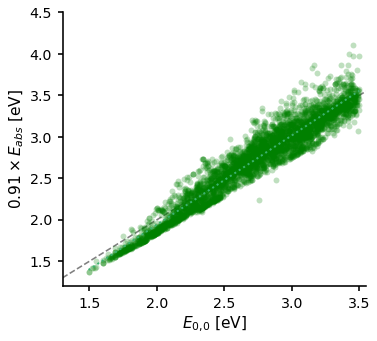

In [14]:
deep4chem_data_b = deep4chem_data.query("E_00 > 1.3 and E_00 < 3.5").copy()
deep4chem_data_b["fit"] = deep4chem_data_b["E_abs"] * 0.91
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.lmplot(data=deep4chem_data_b, x="E_00", y="fit", aspect=1.1,
               scatter_kws={"s": 35,"color":"green","alpha":0.25}, line_kws={"lw": 2,"ls": ":","color":"mediumseagreen"})
g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{0,\!0}$ [eV]'),ylabel=(r'$0.91 \times E_{abs}$ [eV]'))

sns.despine()
plt.xlim(1.3,3.55)
plt.ylim(1.2,4.5)
plt.tight_layout()
# plt.savefig('lambda_max_vs_E00_deep4chem_visible_scaled.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Plot the result of shifting:

<ipython-input-15-539c02062182>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


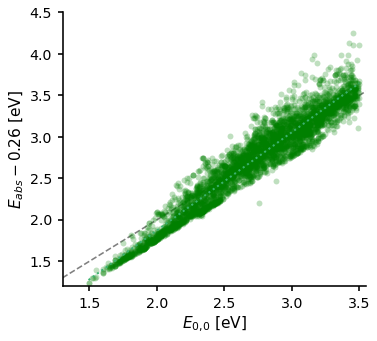

In [15]:
deep4chem_data_b = deep4chem_data.query("E_00 > 1.3 and E_00 < 3.5").copy()
deep4chem_data_b["fit"] = deep4chem_data_b["E_abs"] - 0.26
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.6
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.lmplot(data=deep4chem_data_b, x="E_00", y="fit", aspect=1.1,
               scatter_kws={"s": 35,"color":"green","alpha":0.25}, line_kws={"lw": 2,"ls": ":","color":"mediumseagreen"})
g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{0,\!0}$ [eV]'),ylabel=(r'$E_{abs} - 0.26$ [eV]'))

sns.despine()
plt.xlim(1.3,3.55)
plt.ylim(1.2,4.5)
plt.tight_layout()
# plt.savefig('lambda_max_vs_E00_deep4chem_visible_shifted.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

## Set up the databases

In [16]:
def rename_mols(db):
  df = db.copy()
  df['molecule'].replace({'POZ_3':'POZ_2', 'PA_3':'PA_2'},inplace=True)
  df['molecule'].replace({'POZ_4':'POZ_3'},inplace=True)
  df['molecule'].replace({'POZ_5':'POZ_4'},inplace=True)
  return df

def rename_mols_2(db):
  df = db.copy()
  df['molecule'].replace({'POZ_2':'POZ_3', 'POZ_4':'POZ_5', 'PA_2':'PA_3'},inplace=True)
  return df

In [17]:
# read in the data from files
gs_redox_potentials = pd.read_csv("/content/DFT-ML-excited-state-redox/redox_potentials_raw_2023_02.csv", header=0)
expt_es_redox_potentials = pd.read_csv("/content/DFT-ML-excited-state-redox/expt_excited_potentials_refiltered.csv", header=0)
lambda_maxes = pd.read_csv("/content/DFT-ML-excited-state-redox/E00_data/lambda_abs_maxes_2023_nm.csv", header=0)
acridine_maxes_DCM = pd.read_csv("/content/DFT-ML-excited-state-redox/E00_data/Acr_DCM_lambda_abs_maxes_2023_02_eV.csv", header=0)
emission_maxes = pd.read_csv("/content/DFT-ML-excited-state-redox/E00_data/S1_opt_emissions.csv", header=0)
ML_preds = pd.read_csv("/content/DFT-ML-excited-state-redox/E00_data/ML_preds_3_solvent_separate_models.csv", header=0)

# rename molecules to match filenames with our naming scheme in the TDDFT benchmark paper
# for i in [gs_redox_potentials, expt_es_redox_potentials, lambda_maxes, emission_maxes]:
#   i = rename_mols(i)
ML_preds.replace({'POZ_2':'POZ_3', 'POZ_4':'POZ_5', 'PA_2':'PA_3'}, inplace=True)

# remove TDHF
gs_redox_potentials = gs_redox_potentials.query("functional != 'TDHF'").copy()

# rename the potentials
gs_redox_potentials.rename(columns={"oxidation_potential": "E(M+/M)", "reduction_potential": "E(M/M-)"}, inplace=True)

# prepare the ML data for E_00
ML_E00 = ML_preds.get(["molecule","ML_pred"]).copy()
ML_E00.rename(columns={"ML_pred": "E00_pred"}, inplace=True)

# convert functional names
rename_dict = {'wPBEPP86':'$\\omega$-PBEPP86', 'B2GPPLYP':'B2GP-PLYP', 'RI-SCS-PBE-QIDH':'SCS-PBE-QIDH', 
               'RI-B2PLYP':'B2PLYP', 'RI-wB2PLYP':'$\\omega$-B2PLYP', 'B3LYP-D3':'B3LYP', 
               'CAM-B3LYP-D3':'CAM-B3LYP', 'PBE-D3':'PBE', 'wB97XD':'$\\omega$-B97XD'}
lambda_maxes.replace(rename_dict, inplace=True)
acridine_maxes_DCM.replace(rename_dict, inplace=True)
gs_redox_potentials.replace(rename_dict, inplace=True)

# prepare the data for the absorption E_00 estimate
lambda_maxes['E00_pred'] = 1239.84193 / lambda_maxes['lambda_abs_max']
acridine_maxes_DCM['E00_pred'] = acridine_maxes_DCM['lambda_abs_max']
acridines = acridine_maxes_DCM.molecule.unique()
lambda_maxes_ = pd.concat([acridine_maxes_DCM, lambda_maxes.query("molecule not in @acridines")], ignore_index=True)
abs_E00 = lambda_maxes_.get(["molecule", "functional", "E00_pred"]).copy()

# prepare the data for the adjusted absorption E_00 estimate
abs_E00_adj = abs_E00.copy()
# abs_E00_adj['E00_pred'] = abs_E00_adj['E00_pred'] - 0.26 # use shift
abs_E00_adj['E00_pred'] = abs_E00_adj['E00_pred'] * 0.91 # use scaling

Adjust the calculated ground state potentials using the corresponding organic solvent vs water junction potential. The equations and the junction potential values for ACN and DMF can be found in the [paper of Isse and Gennaro](https://doi.org/10.1021/jp100402x). The DCM values are not corrected due to the lack of literature data and the assumption that for organic solvents the [junction potentials get larger as the dipole moment relative to water increases](https://doi.org/10.1071/CH9741617). Water has a dipole moment of [1.87 D](https://people.chem.umass.edu/xray/solvent.html), whereas DCM has a dipole moment of [1.14 D](https://people.chem.umass.edu/xray/solvent.html) which is considerably lower than the [3.44 and 3.86 D](https://people.chem.umass.edu/xray/solvent.html) values for ACN and DMF.

In [18]:
all_mols = gs_redox_potentials.molecule.unique()
ACN_mols = ["Mes-Acr_1", "Rh_B", "Rh_6G"] + [i for i in all_mols if "Ph-Acr" in i or "CA" in i or "Eos" in i or "NCE" in i]
DCM_mols = [i for i in all_mols if "BOH-Acr" in i or "BF3-Acr" in i or "PDI" in i]
DMF_mols = [i for i in all_mols if "Me2-Acr" in i or "PA_" in i or "POZ" in i or "PTZ" in i]
# len(all_mols) == len(ACN_mols+DCM_mols+DMF_mols) # test passed
ACN_mols_ = dict(zip(ACN_mols, len(ACN_mols)*["ACN"]))
DCM_mols_ = dict(zip(DCM_mols, len(DCM_mols)*["DCM"]))
DMF_mols_ = dict(zip(DMF_mols, len(DMF_mols)*["DMF"]))
mols_solv_pairs = {**ACN_mols_, **DCM_mols_, **DMF_mols_}

In [19]:
gs_redox_potentials["solvent"] = gs_redox_potentials["molecule"]
gs_redox_potentials.replace({"solvent" : mols_solv_pairs}, inplace=True)

gs_redox_potentials.loc[(gs_redox_potentials['solvent'] == "ACN") & (gs_redox_potentials['functional'] != "experiment"), 'E(M+/M)'] += 0.093 # 0.141
gs_redox_potentials.loc[(gs_redox_potentials['solvent'] == "ACN") & (gs_redox_potentials['functional'] != "experiment"), 'E(M/M-)'] += 0.093 # 0.141
gs_redox_potentials.loc[(gs_redox_potentials['solvent'] == "DMF") & (gs_redox_potentials['functional'] != "experiment"), 'E(M+/M)'] += 0.172 # 0.099
gs_redox_potentials.loc[(gs_redox_potentials['solvent'] == "DMF") & (gs_redox_potentials['functional'] != "experiment"), 'E(M/M-)'] += 0.172 # 0.099
gs_redox_potentials

,molecule,functional,E(M+/M),E(M/M-),solvent
0,BF3-Acr_m,experiment,1.690000,-0.700000,DCM
1,BF3-Acr_o,experiment,1.780000,-0.970000,DCM
2,BF3-Acr_p,experiment,1.710000,-0.800000,DCM
3,BOH-Acr_m,experiment,1.590000,-0.670000,DCM
4,BOH-Acr_o,experiment,1.600000,-0.580000,DCM
...,...,...,...,...,...
658,PTZ_1,$\omega$-B97XD,0.533295,-3.086975,DMF
659,PTZ_2,$\omega$-B97XD,0.689349,-2.866470,DMF
660,PTZ_3,$\omega$-B97XD,0.637994,-2.489406,DMF
661,Rh_6G,$\omega$-B97XD,1.076090,-1.070891,ACN


Calculate the excited state redox potentials using the gs redox potentials and the two E_00 estimations:

In [20]:
# the ML estimate
ML_es_preds = gs_redox_potentials.merge(ML_E00)
ML_es_preds["E(M+/M*)"] = ML_es_preds["E(M+/M)"] - ML_es_preds["E00_pred"]
ML_es_preds["E(M*/M-)"] = ML_es_preds["E(M/M-)"] + ML_es_preds["E00_pred"]
ML_es_preds_toplot = ML_es_preds.query("functional != 'experiment'").get(["molecule","functional","E(M+/M*)","E(M*/M-)"]).copy()
# the absorption estimate
abs_es_preds = gs_redox_potentials.merge(abs_E00)
abs_es_preds["E(M+/M*)"] = abs_es_preds["E(M+/M)"] - abs_es_preds["E00_pred"]
abs_es_preds["E(M*/M-)"] = abs_es_preds["E(M/M-)"] + abs_es_preds["E00_pred"]
abs_es_preds_toplot = abs_es_preds.query("functional != 'experiment'").get(["molecule","functional","E(M+/M*)","E(M*/M-)"]).copy()
# the adjusted absorption estimate
abs_adj_es_preds = gs_redox_potentials.merge(abs_E00_adj)
abs_adj_es_preds["E(M+/M*)"] = abs_adj_es_preds["E(M+/M)"] - abs_adj_es_preds["E00_pred"]
abs_adj_es_preds["E(M*/M-)"] = abs_adj_es_preds["E(M/M-)"] + abs_adj_es_preds["E00_pred"]
abs_adj_es_preds_toplot = abs_adj_es_preds.query("functional != 'experiment'").get(["molecule","functional","E(M+/M*)","E(M*/M-)"]).copy()

Convert the two excited state redox potential databases to long format:

In [21]:
# the ML estimate
ML_es_preds_toplot_long = pd.melt(ML_es_preds_toplot, 
                               id_vars=["molecule","functional"],
                               value_vars=ML_es_preds_toplot.columns[2:], # fist two columns are 'molecule', 'functional', rest are the potentials
                               var_name="potential_type",
                               value_name="predicted_value")

ML_es_expts_long = expt_es_redox_potentials.get(["molecule","E(M+/M*)","E(M*/M-)"])
ML_es_expts_long = pd.melt(ML_es_expts_long, 
                        id_vars=["molecule"],
                        value_vars=["E(M+/M*)","E(M*/M-)"],
                        var_name="potential_type",
                        value_name="actual_value")

ML_es_data_toplot = ML_es_preds_toplot_long.merge(ML_es_expts_long)

In [22]:
# the absorption estimate
abs_es_preds_toplot_long = pd.melt(abs_es_preds_toplot, 
                               id_vars=["molecule","functional"],
                               value_vars=abs_es_preds_toplot.columns[2:], # fist two columns are 'molecule', 'functional', rest are the potentials
                               var_name="potential_type",
                               value_name="predicted_value")

abs_es_expts_long = expt_es_redox_potentials.get(["molecule","E(M+/M*)","E(M*/M-)"])
abs_es_expts_long = pd.melt(abs_es_expts_long, 
                        id_vars=["molecule"],
                        value_vars=["E(M+/M*)","E(M*/M-)"],
                        var_name="potential_type",
                        value_name="actual_value")

abs_es_data_toplot = abs_es_preds_toplot_long.merge(abs_es_expts_long)

In [23]:
# the adjusted absorption estimate
abs_adj_es_preds_toplot_long = pd.melt(abs_adj_es_preds_toplot, 
                               id_vars=["molecule","functional"],
                               value_vars=abs_adj_es_preds_toplot.columns[2:], # fist two columns are 'molecule', 'functional', rest are the potentials
                               var_name="potential_type",
                               value_name="predicted_value")

abs_adj_es_expts_long = expt_es_redox_potentials.get(["molecule","E(M+/M*)","E(M*/M-)"])
abs_adj_es_expts_long = pd.melt(abs_adj_es_expts_long, 
                        id_vars=["molecule"],
                        value_vars=["E(M+/M*)","E(M*/M-)"],
                        var_name="potential_type",
                        value_name="actual_value")

abs_adj_es_data_toplot = abs_adj_es_preds_toplot_long.merge(abs_adj_es_expts_long)

In [24]:
func_order = ['$\\omega$-PBEPP86', '$\\omega$-B2PLYP', 'B2PLYP', 'B2GP-PLYP', 'SCS-PBE-QIDH', 'DSD-BLYP',
              '$\\omega$-B97XD', 'CAM-B3LYP', 'B3LYP', 'M06', 'M062X',
              'M06L', 'TPSS', 'B97D3', 'PBE', 'TDHF', 'experiment']
func_order_DFTonly = func_order[:-2]

ML_es_data_toplot['functional'] = pd.Categorical(ML_es_data_toplot['functional'],categories=func_order_DFTonly,ordered=True)
ML_es_data_toplot = ML_es_data_toplot.sort_values(['functional'], ignore_index=True)

abs_es_data_toplot['functional'] = pd.Categorical(abs_es_data_toplot['functional'],categories=func_order_DFTonly,ordered=True)
abs_es_data_toplot = abs_es_data_toplot.sort_values(['functional'], ignore_index=True)

abs_adj_es_data_toplot['functional'] = pd.Categorical(abs_adj_es_data_toplot['functional'],categories=func_order_DFTonly,ordered=True)
abs_adj_es_data_toplot = abs_adj_es_data_toplot.sort_values(['functional'], ignore_index=True)

## Plot the data

### Correlation plots

<ipython-input-25-fe510ff35002>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


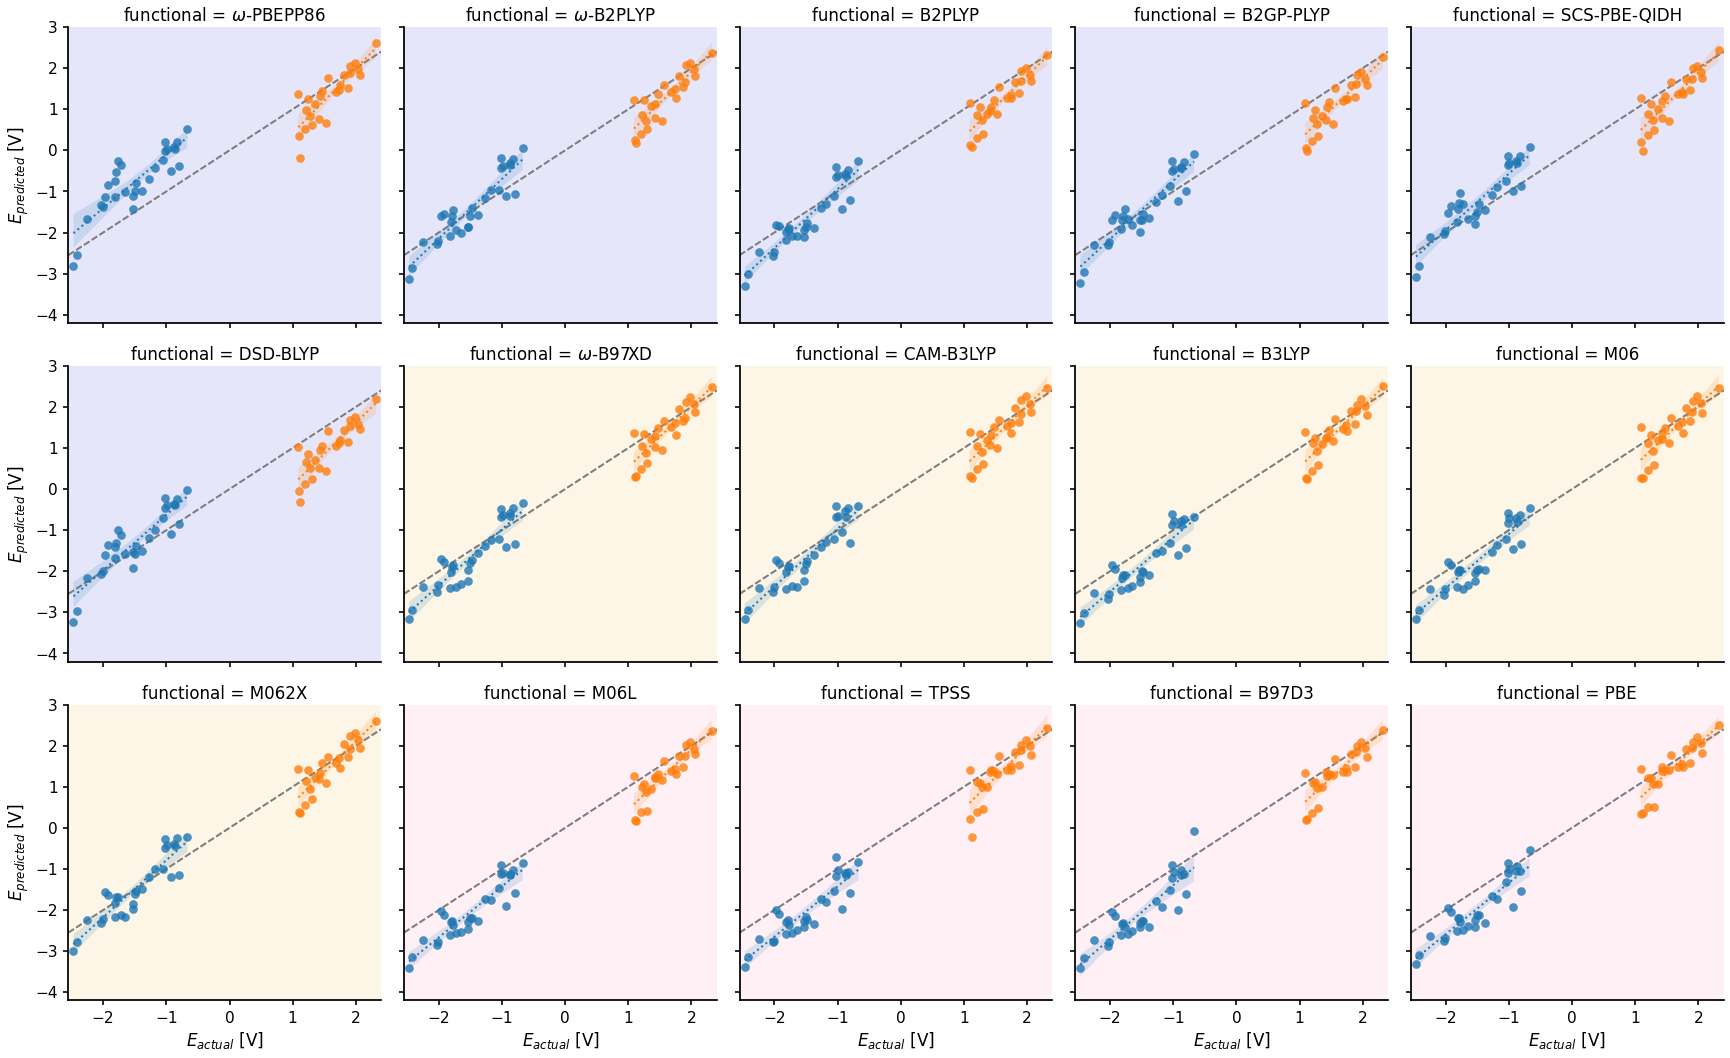

In [25]:
# the ML estimate (E_0,0 = E_ML)
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=ML_es_data_toplot, aspect=0.9,
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.2,3.)
plt.tight_layout()
# plt.savefig(f'ML_es_redox.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-26-bc5d6d5970ab>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


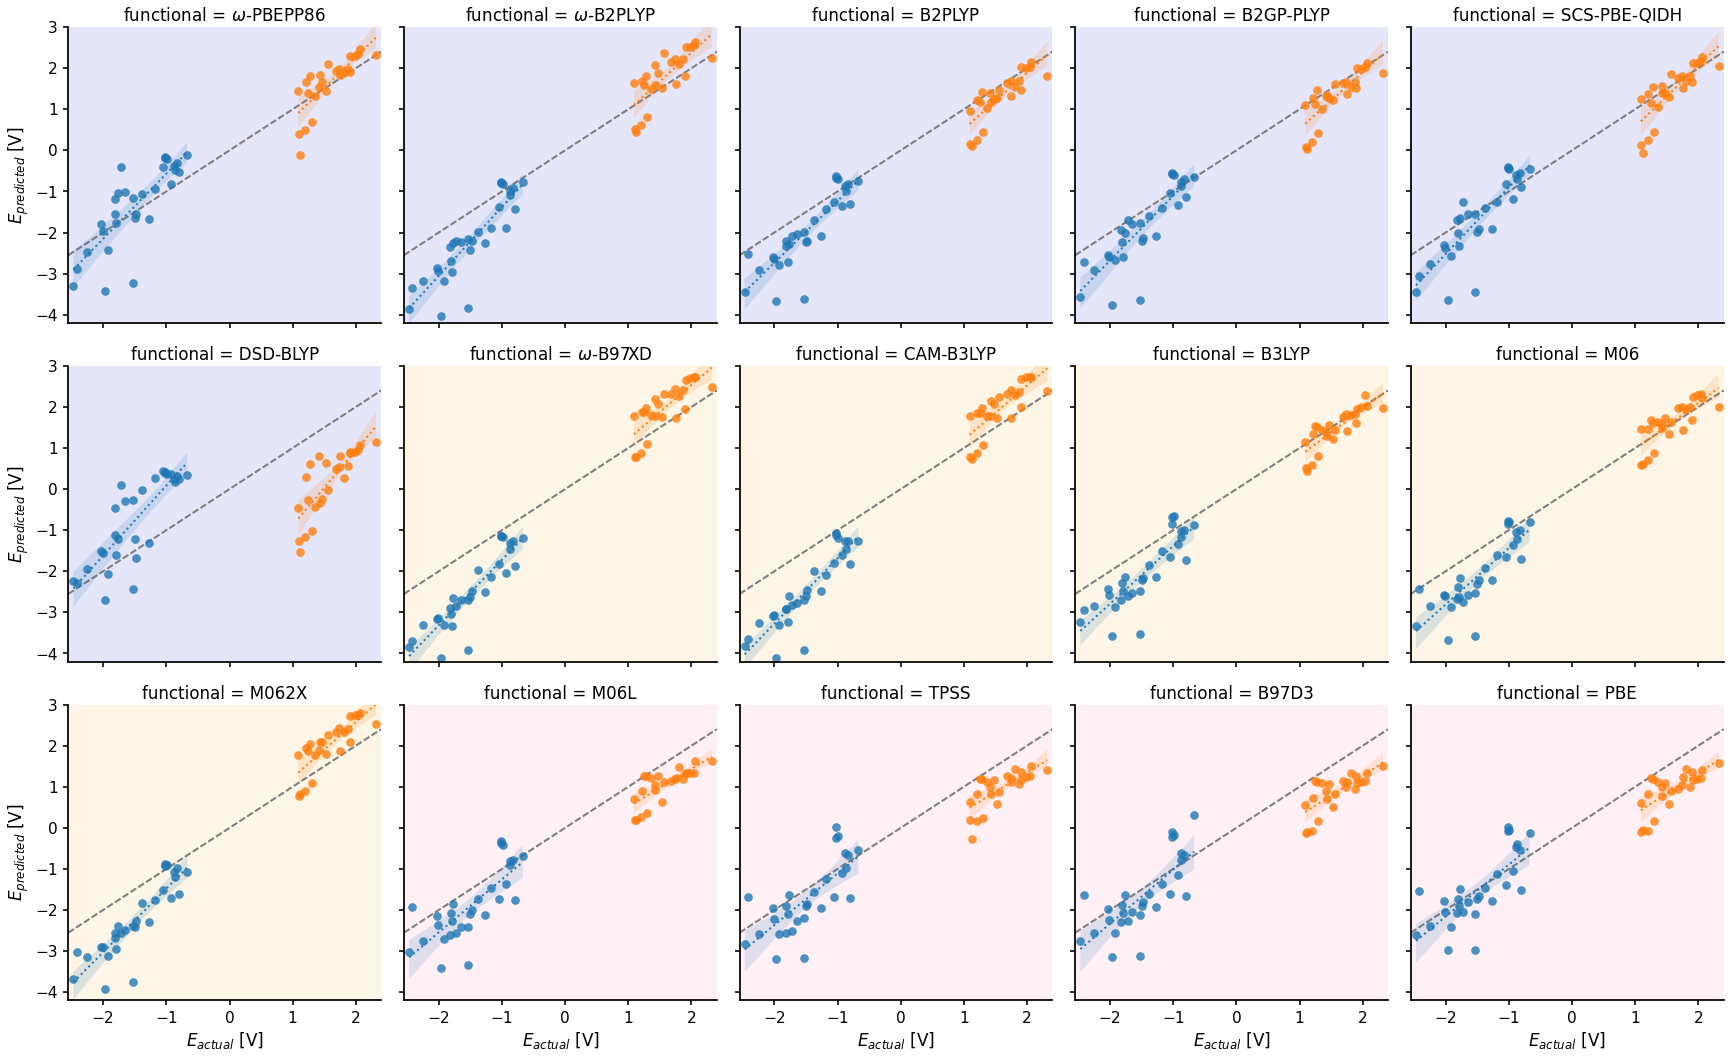

In [26]:
# the absorption estimate (E_0,0 = E_abs)
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=abs_es_data_toplot, aspect=0.9,
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.2,3.)
plt.tight_layout()
# plt.savefig(f'abs_es_redox.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-27-f6eec003b00a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


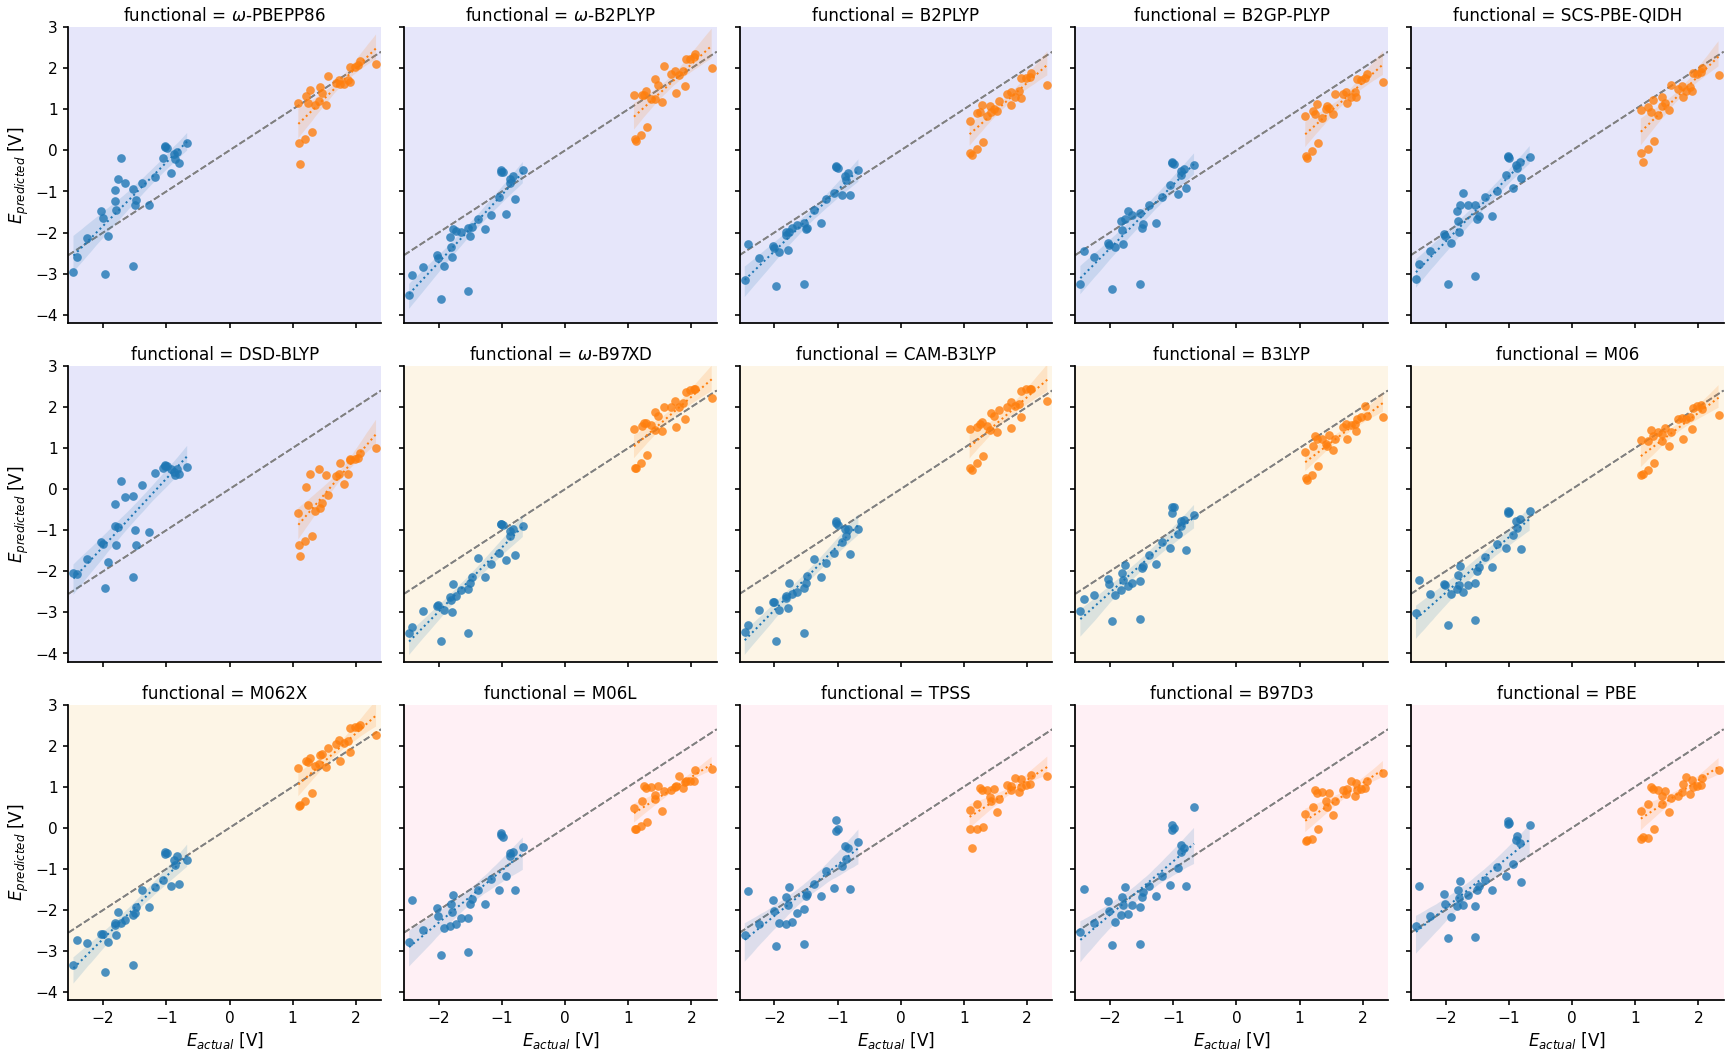

In [27]:
# the scaled absorption estimate (E_0,0 = 0.91*E_abs)
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=abs_adj_es_data_toplot, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.2,3.)
plt.tight_layout()
# plt.savefig(f'abs_adj_es_redox.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

In [28]:
abs_adj_es_data_toplot.groupby("potential_type").mean()

,predicted_value,actual_value
potential_type,,
E(M*/M-),0.907979,1.575200
E(M+/M*),-1.447783,-1.485333


In [29]:
abs_es_data_toplot.groupby("potential_type").mean()

,predicted_value,actual_value
potential_type,,
E(M*/M-),1.165888,1.575200
E(M+/M*),-1.705692,-1.485333


### MAE plots

Calculate the errors:

In [30]:
# prepare the ML data
ML_es_data_toplot["delta"] = abs(ML_es_data_toplot["predicted_value"] - ML_es_data_toplot["actual_value"])
# ML_es_data_toplot.query("potential_type == 'E(M+/M*)'").groupby(['functional'], as_index=False).mean()
# prepare the absorption data
abs_es_data_toplot["delta"] = abs(abs_es_data_toplot["predicted_value"] - abs_es_data_toplot["actual_value"])
# abs_es_data_toplot.query("potential_type == 'E(M+/M*)'").groupby(['functional'], as_index=False).mean()
# prepare the adjusted absorption data
abs_adj_es_data_toplot["delta"] = abs(abs_adj_es_data_toplot["predicted_value"] - abs_adj_es_data_toplot["actual_value"])

Plot the errors:

<ipython-input-31-c2196befc5af>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


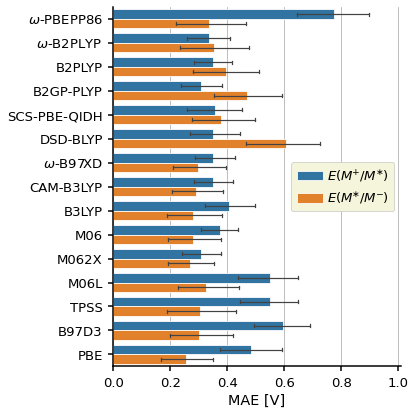

In [31]:
# the ML estimate
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=ML_es_data_toplot.replace({"E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}), 
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
# ax.legend(frameon=True, title=None, loc='upper right', facecolor="white", framealpha=1, bbox_to_anchor=(1.01, 1.03))
# ax.legend(frameon=True, title=None, loc='center', facecolor="white", framealpha=1, ncol=2, bbox_to_anchor=(0.5, 1.04))
ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig(f'ML_es_redox_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-32-969ba3a1fe51>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


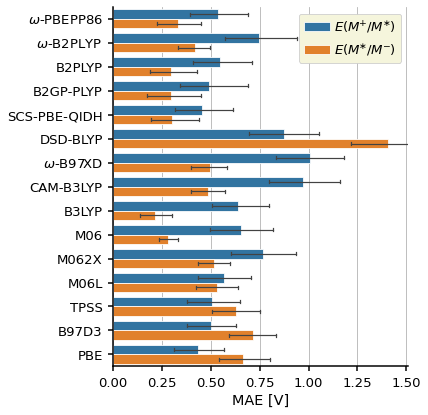

In [32]:
# the absorption estimate
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=abs_es_data_toplot.replace({"E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}),
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.51)
plt.tight_layout()
# plt.savefig(f'abs_es_redox_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-33-3a17bb2746d5>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


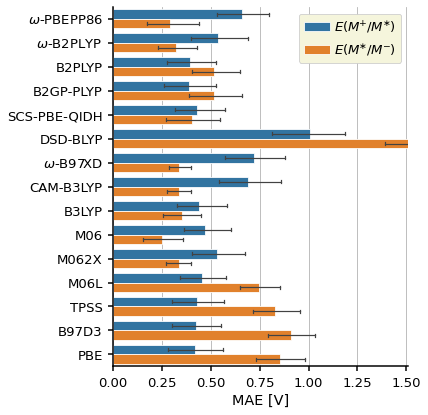

In [33]:
# the scaled absorption estimate
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=abs_adj_es_data_toplot.replace({"E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}),
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.51)
plt.tight_layout()
# plt.savefig(f'abs_adj_es_redox_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

### ES potentials with GS redox shift

In [34]:
abs_adj_shifted_es_data_toplot = abs_adj_es_data_toplot.copy()
abs_adj_shifted_es_data_toplot['predicted_value'] = abs_adj_shifted_es_data_toplot['predicted_value'] + 0.2
abs_adj_shifted_es_data_toplot['delta'] = abs(abs_adj_shifted_es_data_toplot['predicted_value'] - abs_adj_shifted_es_data_toplot['actual_value'])

<ipython-input-35-7dafd716bc2d>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


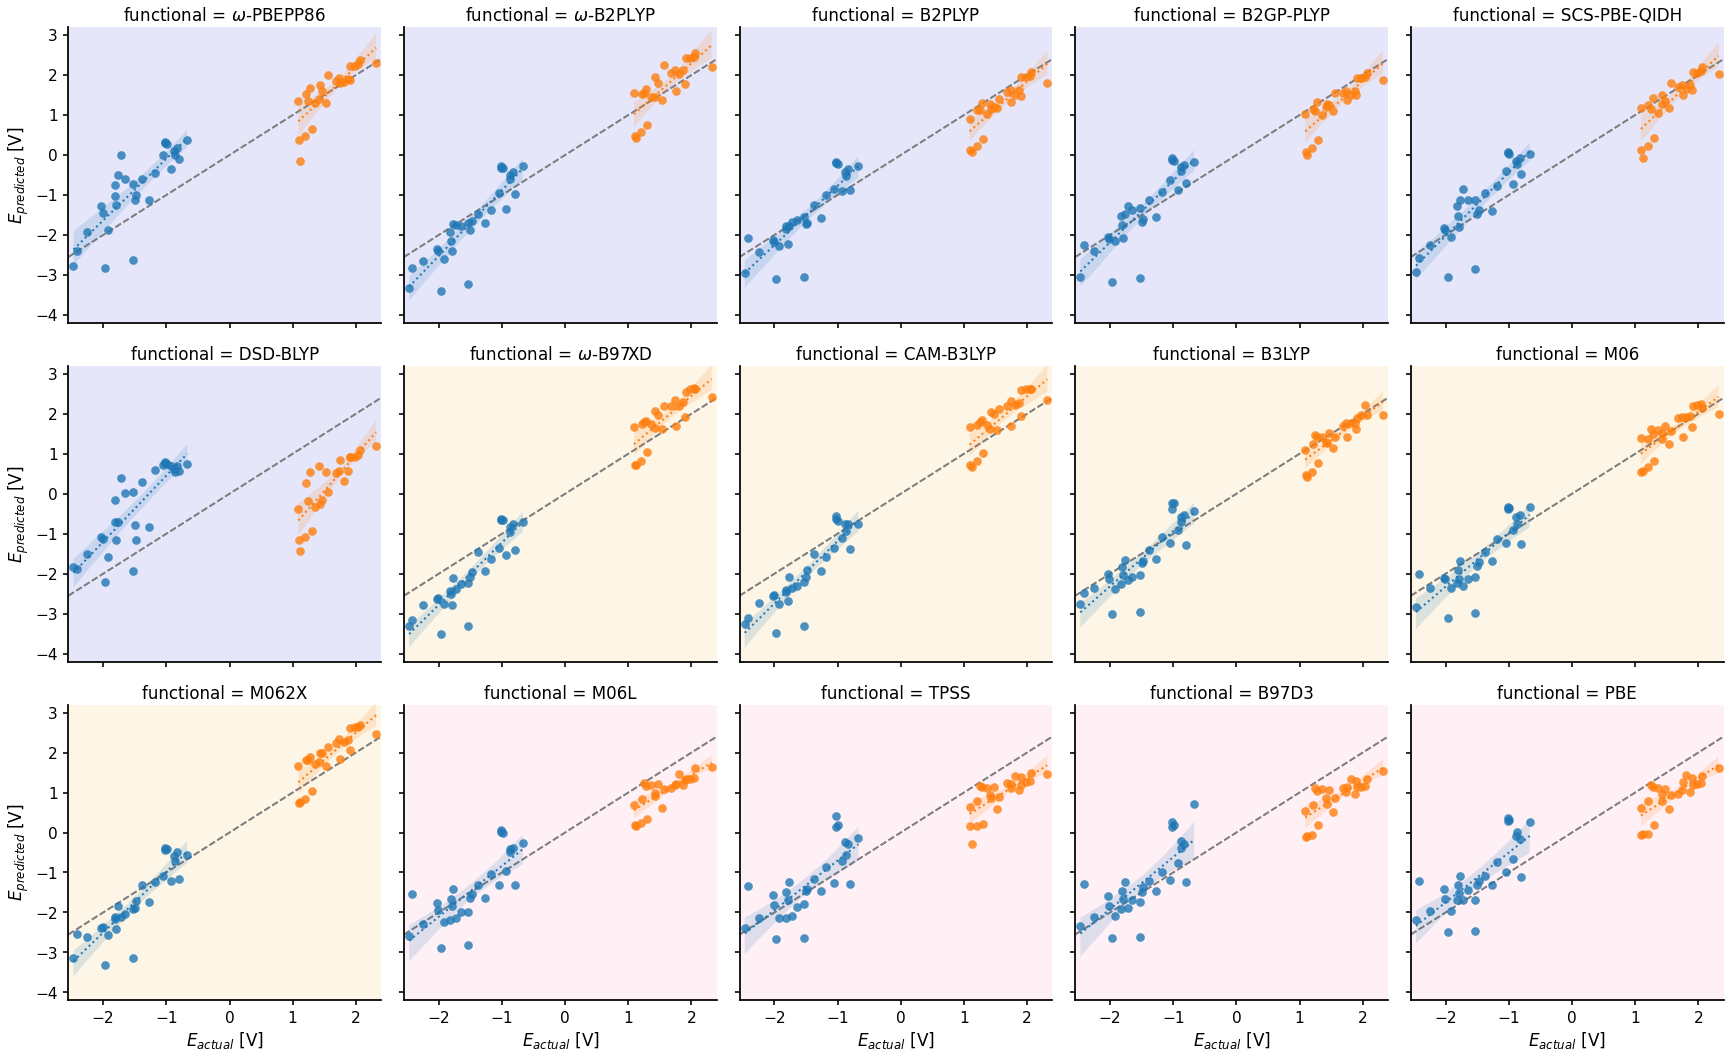

In [35]:
# the scaled absorption estimate with a constant ground state redox shift of 0.2 V
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=abs_adj_shifted_es_data_toplot, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.2,3.2)
plt.tight_layout()
# plt.savefig(f'abs_adj_shifted_es_redox.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-36-cb888c0f3b22>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


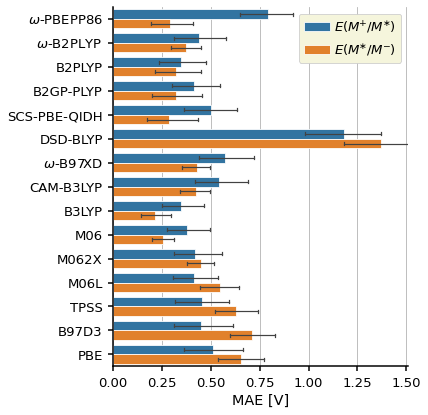

In [36]:
# the scaled absorption estimate with a constant ground state redox shift of 0.2 V
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=abs_adj_shifted_es_data_toplot.replace({"E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}),
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.51)
plt.tight_layout()
# plt.savefig(f'abs_adj_shifted_es_redox_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Now let's introduce the functional specific ground state potential shifts we have obtained from the ground state investigations:

In [37]:
gs_shifts_data = pd.read_csv("/content/DFT-ML-excited-state-redox/optimized_shifts.csv", header=0)

gs_shifts_data_long = pd.melt(gs_shifts_data, 
                              id_vars=["functional"],
                              value_vars=["E(M+/M)_shift", "E(M/M-)_shift"], # fist two columns are 'molecule', 'functional', rest are the potentials
                              var_name="potential_type",
                              value_name="shift")

gs_shifts_data_long.replace({"E(M+/M)_shift": "E(M+/M*)", "E(M/M-)_shift": "E(M*/M-)"}, inplace=True)

In [38]:
abs_adj_FuncDepGS_Shift_es_data_toplot = abs_adj_es_data_toplot.merge(gs_shifts_data_long)
abs_adj_FuncDepGS_Shift_es_data_toplot["predicted_value"] += abs_adj_FuncDepGS_Shift_es_data_toplot["shift"]
abs_adj_FuncDepGS_Shift_es_data_toplot['delta'] = abs(abs_adj_FuncDepGS_Shift_es_data_toplot['predicted_value'] - abs_adj_FuncDepGS_Shift_es_data_toplot['actual_value'])

<ipython-input-39-87b5bfcbe450>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


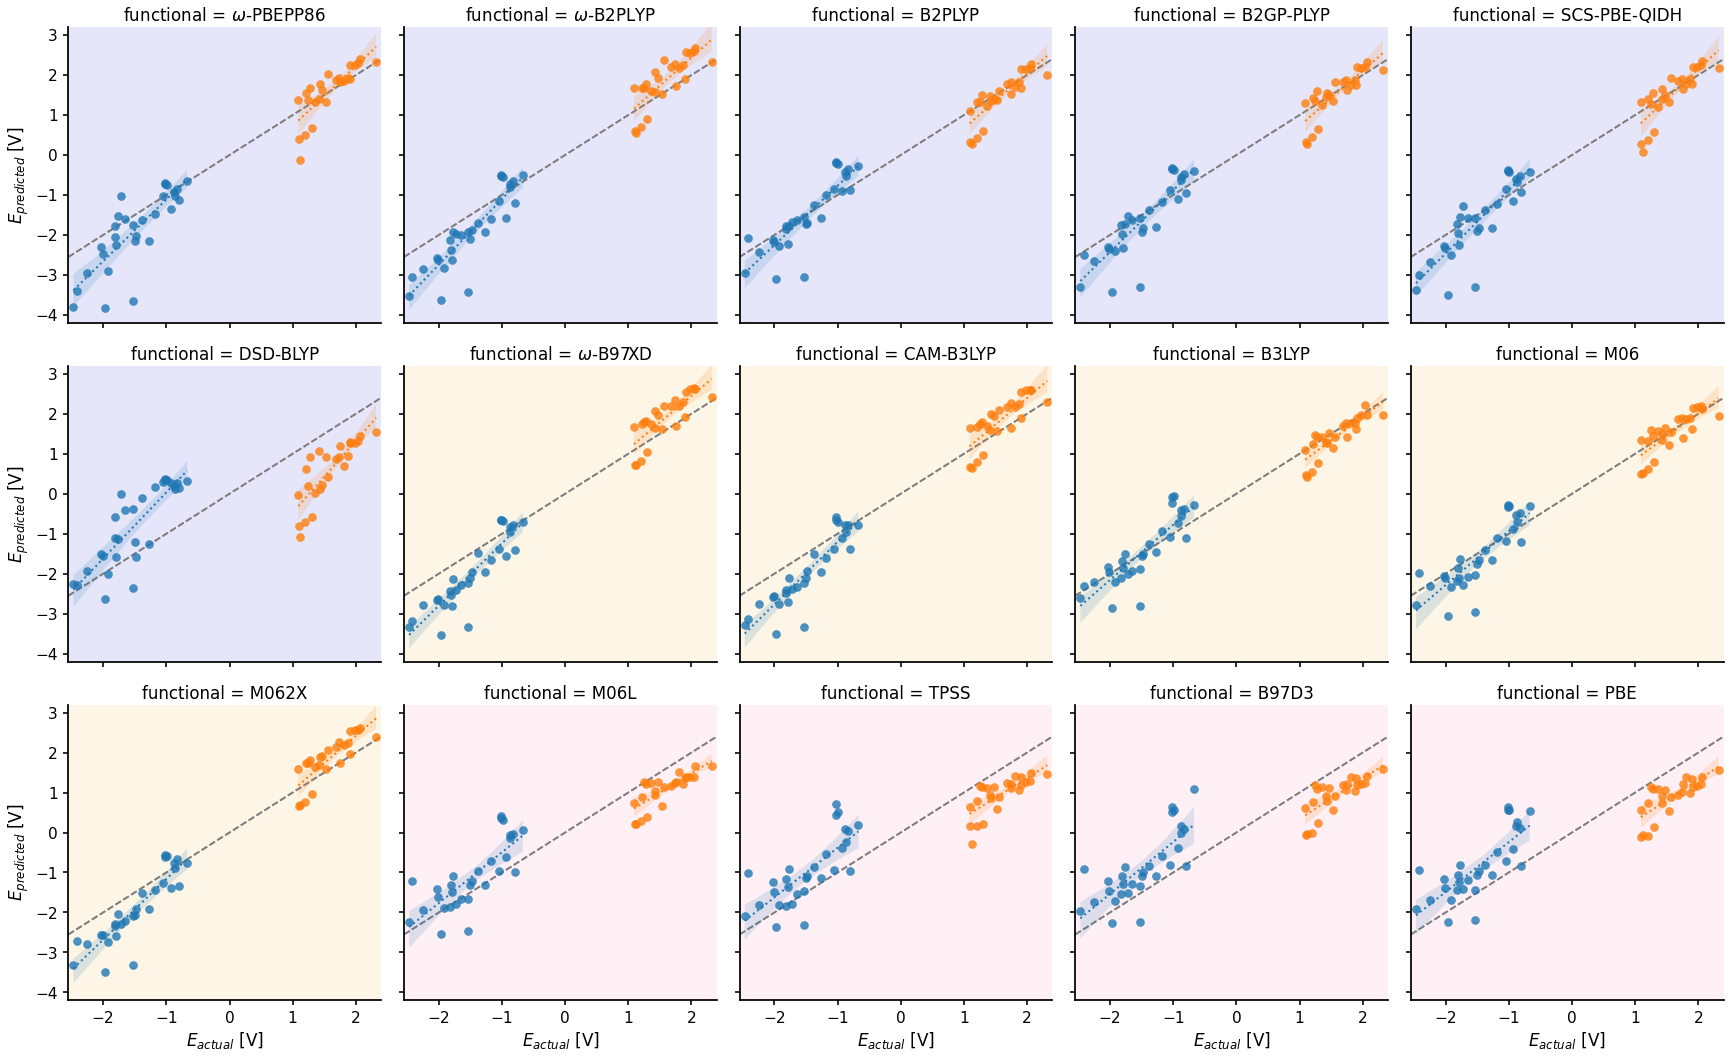

In [39]:
# the scaled absorption estimate with functional-specific ground state redox shift
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", col='functional', hue='potential_type', 
               col_wrap=5, data=abs_adj_FuncDepGS_Shift_es_data_toplot, aspect=0.9, 
               scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

for N, i in enumerate(g.axes.flat):
  if N < 6: # double hybrids
    i.set_facecolor("lavender")
  if N >= 6 and N < 11: # hybrids
    i.set_facecolor("oldlace")
  if N >= 11: # pure functionals
    i.set_facecolor("lavenderblush")

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.2,3.2)
plt.tight_layout()
# plt.savefig(f'abs_adj_FuncDepGS_Shift_es_redox.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

<ipython-input-40-e2648b7c5744>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


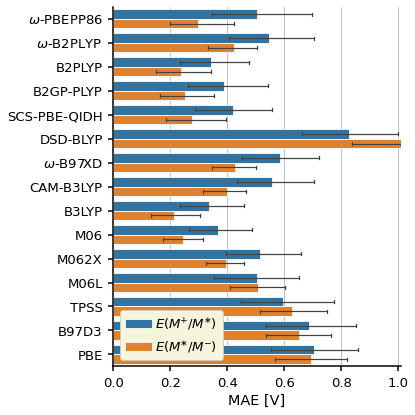

In [40]:
# the adjusted absorption estimate with functional-specific ground state redox shift
sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=scale, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

plt.figure(figsize=(6,6))
ax = sns.barplot(data=abs_adj_FuncDepGS_Shift_es_data_toplot.replace({"E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}),
                 x="delta", y="functional", hue="potential_type", edgecolor="white", errwidth=1.2, capsize=.125)
ax.set(xlabel=r'MAE [V]', ylabel=None)
ax.legend(frameon=True, title=None, loc='best', facecolor="beige", framealpha=1, #bbox_to_anchor=(0.5, 1.04), 
          ncols=1, handletextpad=0.3)

ax.grid(axis = 'x')
ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig(f'abs_adj_FuncDepGS_Shift_es_redox_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

Print some statistics:

In [41]:
b3lyp_mae = abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'B3LYP'").delta.mean().round(4)
print(f"B3LYP overall MAE: {b3lyp_mae}")
m06_mae = abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'M06'").delta.mean().round(4)
print(f"M06 overall MAE: {m06_mae}")
b2plyp_mae = abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'B2PLYP'").delta.mean().round(4)
print(f"B2PLYP overall MAE: {b2plyp_mae}")

B3LYP overall MAE: 0.2812
M06 overall MAE: 0.3131
B2PLYP overall MAE: 0.2967


In [42]:
abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'B3LYP'").groupby("potential_type", as_index=False).mean()

,potential_type,predicted_value,actual_value,delta,shift
0,E(M*/M-),1.195925,1.575200,0.213655,0.20
1,E(M+/M*),-1.293849,-1.485333,0.337483,0.36


In [43]:
abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'M06'").delta.mean()

0.3131123310497529

In [44]:
abs_adj_FuncDepGS_Shift_es_data_toplot.query("functional == 'M06'").groupby("potential_type", as_index=False).mean()

,potential_type,predicted_value,actual_value,delta,shift
0,E(M*/M-),1.282150,1.575200,0.245471,0.16
1,E(M+/M*),-1.437987,-1.485333,0.369480,0.24


In [45]:
np.setdiff1d(np.sort(gs_redox_potentials.molecule.unique().astype("str")), np.sort(abs_adj_FuncDepGS_Shift_es_data_toplot.molecule.unique().astype("str")))

array(['Me2-Acr_1', 'PA_2', 'POZ_2', 'POZ_4'], dtype='<U9')

> **Note**: We do not have excited state redox data for the four molecules above.

In [46]:
abs_adj_es_data_toplot.query("functional == 'M06'").groupby("potential_type", as_index=False).mean()

,potential_type,predicted_value,actual_value,delta
0,E(M*/M-),1.122150,1.575200,0.251497
1,E(M+/M*),-1.677987,-1.485333,0.469291


In [47]:
abs_adj_es_data_toplot.query("functional == 'SCS-PBE-QIDH'").groupby("potential_type", as_index=False).mean()

,potential_type,predicted_value,actual_value,delta
0,E(M*/M-),0.986778,1.575200,0.403325
1,E(M+/M*),-1.241343,-1.485333,0.428493


In [48]:
abs_adj_es_data_toplot.groupby("potential_type", as_index=False).mean()

,potential_type,predicted_value,actual_value,delta
0,E(M*/M-),0.907979,1.575200,0.571978
1,E(M+/M*),-1.447783,-1.485333,0.532178


## Improving the absorption estimate with emission calculations

Get the emission data and convert it to usable form:

In [49]:
AbsEm_E00 = emission_maxes.get(['molecule', 'functional', 'lambda_abs_max']).copy()
AbsEm_E00.replace(rename_dict, inplace=True)
AbsEm_E00 = AbsEm_E00.merge(lambda_maxes.get(['molecule', 'functional', 'E00_pred']), how='left')
AbsEm_E00.rename(columns={"lambda_abs_max":"E_em", "E00_pred": "E_abs"}, inplace=True)
AbsEm_E00['E00_pred'] = (AbsEm_E00['E_em'] + AbsEm_E00['E_abs'])/2

In [50]:
AbsEm_es_preds = gs_redox_potentials.merge(AbsEm_E00, how='inner')
AbsEm_es_preds["E(M+/M*)"] = AbsEm_es_preds["E(M+/M)"] - AbsEm_es_preds["E00_pred"]
AbsEm_es_preds["E(M*/M-)"] = AbsEm_es_preds["E(M/M-)"] + AbsEm_es_preds["E00_pred"]
AbsEm_es_preds_toplot = AbsEm_es_preds.query("functional != 'experiment'").get(["molecule","functional","E(M+/M*)","E(M*/M-)"]).copy()

In [51]:
AbsEm_es_preds_toplot_long = pd.melt(AbsEm_es_preds_toplot, 
                               id_vars=["molecule","functional"],
                               value_vars=AbsEm_es_preds_toplot.columns[2:], # fist two columns are 'molecule', 'functional', rest are the potentials
                               var_name="potential_type",
                               value_name="predicted_value")

AbsEm_es_expts_long = expt_es_redox_potentials.get(["molecule","E(M+/M*)","E(M*/M-)"])
AbsEm_es_expts_long = pd.melt(AbsEm_es_expts_long, 
                        id_vars=["molecule"],
                        value_vars=["E(M+/M*)","E(M*/M-)"],
                        var_name="potential_type",
                        value_name="actual_value")

AbsEm_es_data_toplot = AbsEm_es_preds_toplot_long.merge(AbsEm_es_expts_long)
AbsEm_es_data_toplot["delta"] = abs(AbsEm_es_data_toplot["predicted_value"] - AbsEm_es_data_toplot["actual_value"])

In [52]:
functionals = ['M06', 'M062X', 'PBE']
ML_part = ML_es_data_toplot.query("functional in @functionals").copy()
abs_adj_part = abs_adj_es_data_toplot.query("functional in @functionals").copy()
AbsEm_part = AbsEm_es_data_toplot.copy()

ML_part.rename(columns={"predicted_value":"ML_pred", "delta": "ML_delta"}, inplace=True)
abs_adj_part.rename(columns={"predicted_value":"abs_adj_pred", "delta": "abs_adj_delta"}, inplace=True)
AbsEm_part.rename(columns={"predicted_value":"AbsEm_pred", "delta": "AbsEm_delta"}, inplace=True)

threefunc_data = AbsEm_part.merge(abs_adj_part.merge(ML_part, how='inner'), how='inner')

In [53]:
# convert to long format
threefunc_data_long_preds = pd.melt(threefunc_data.drop(columns=['AbsEm_delta','abs_adj_delta','ML_delta']), 
                                    id_vars=["molecule","functional","potential_type","actual_value"],
                                    value_vars=['AbsEm_pred','abs_adj_pred','ML_pred'],
                                    var_name="prediction_type",
                                    value_name="predicted_value")

threefunc_data_long_deltas = pd.melt(threefunc_data.drop(columns=['AbsEm_pred','abs_adj_pred','ML_pred']), 
                                     id_vars=["molecule","functional","potential_type","actual_value"],
                                     value_vars=['AbsEm_delta','abs_adj_delta','ML_delta'],
                                     var_name="prediction_type",
                                     value_name="delta")

threefunc_data_long_preds.replace({'AbsEm_pred':'AbsEm', 'abs_adj_pred':'abs_adj', 'ML_pred':'ML'}, inplace=True)
threefunc_data_long_deltas.replace({'AbsEm_delta':'AbsEm', 'abs_adj_delta':'abs_adj', 'ML_delta':'ML'}, inplace=True)

threefunc_data_long = threefunc_data_long_preds.merge(threefunc_data_long_deltas)

In [54]:
M06_es_shifted = threefunc_data_long.query("functional == 'M06'").drop(columns=['functional','delta']).copy()
M06_es_shifted["predicted_value"] = M06_es_shifted["predicted_value"] + 0.2
M06_es_shifted["delta"] = abs(M06_es_shifted["predicted_value"] - M06_es_shifted["actual_value"])

In [55]:
M06_es_shifted['functional'] = r'$\mathregular{M06_{adj}}$'
threefunc_data_long_ext = threefunc_data_long.query("functional in ['M06', 'M062X']").append(M06_es_shifted)
errplot_data = threefunc_data_long_ext.rename(columns={"prediction_type":r'$E_{0,\!0}$'}).replace({"AbsEm":r'$E_{avg}$', "abs_adj":r'$E_{abs,adj}$', "ML":r'$E_{ML}$', 
                                                                                                   "E(M+/M*)":r'$E(M\! ^+\! / M\! ^\ast\!)$', "E(M*/M-)":r'$E(M\! ^\ast\! / M\! ^-\!)$'}).copy()

<ipython-input-56-31b63789bec8>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


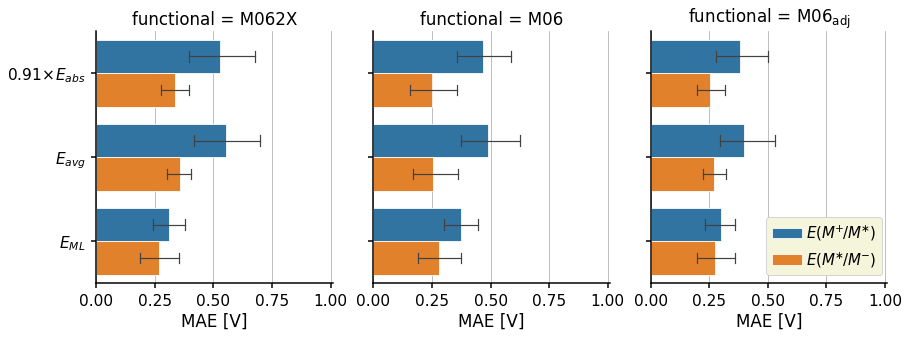

In [56]:
# M062X and M06 MAEs for the three types of approximations
threeapprox_plot = errplot_data.replace({r'$E_{abs,adj}$':r'$0.91 \! \times \! E_{abs}$'})

sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.FacetGrid(threeapprox_plot, col="functional", col_order=['M062X', 'M06', r'$\mathregular{M06_{adj}}$'], height=5, aspect=0.75)
g.map_dataframe(sns.barplot, x="delta", y=r'$E_{0,\!0}$', hue="potential_type", order=[r'$0.91 \! \times \! E_{abs}$', r'$E_{avg}$', r'$E_{ML}$'],
                edgecolor="white", errwidth=1.2, capsize=.125, palette=sns.color_palette())
g.set(xlabel=r'MAE [V]', ylabel=None)
g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, handletextpad=0.3, bbox_to_anchor=(0.901, 0.285), fontsize=15)

# ax.set(xlabel=r'MAE [V]', ylabel=None)
# ax.legend(frameon=True, title=None, loc='center', facecolor="white", framealpha=1, ncol=2, bbox_to_anchor=(0.5, 1.04))
# ax.grid(axis = 'x')
# ax.set_axisbelow(True)
for ax in g.axes.flat:
  ax.grid(True, axis='x')
  ax.set_axisbelow(True)
sns.despine()
plt.xlim(0,1.01)
plt.tight_layout()
# plt.savefig(f'M062X_M06_M06-adj_MAE.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-57-b789e6f3c060>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


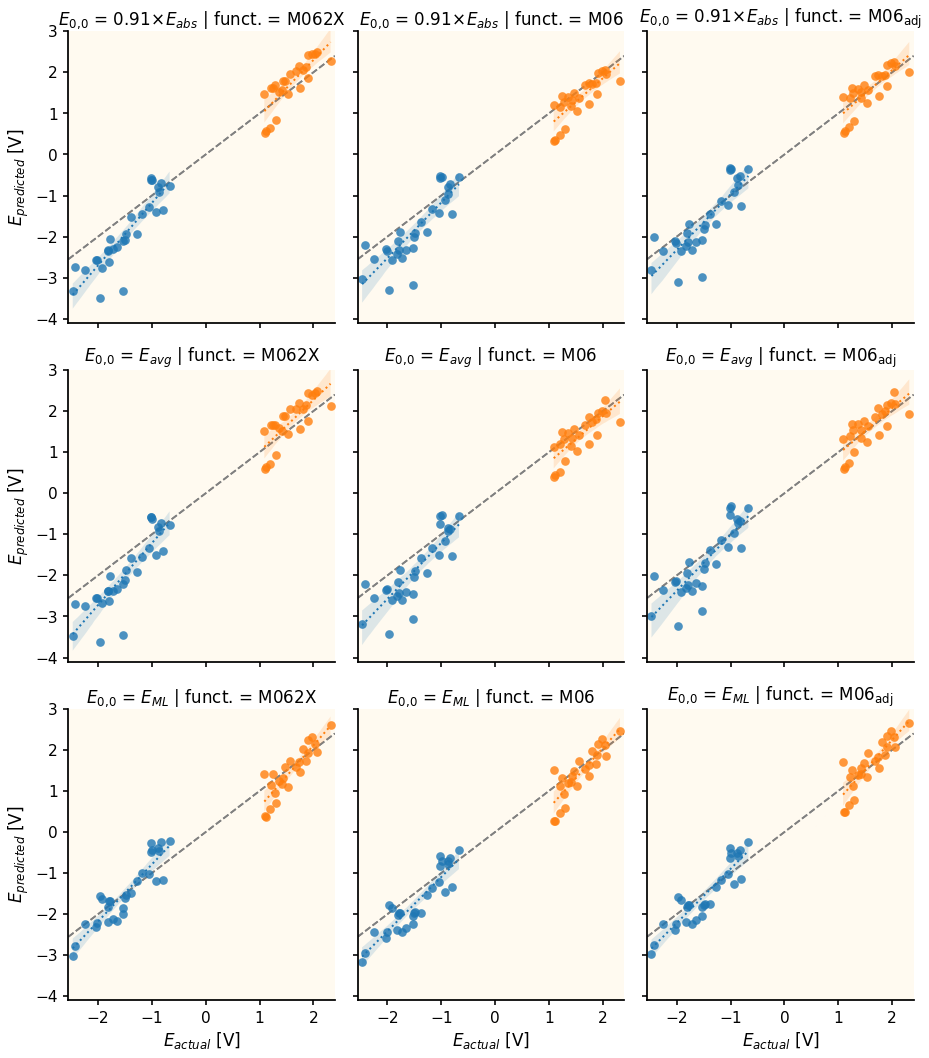

In [57]:
threeapprox_plot = errplot_data.replace({r'$E_{abs,adj}$':r'$0.91 \! \times \! E_{abs}$'}).rename(columns={"functional":"funct."})

# correlation plots for the three types of approximations
sns.reset_orig()
plt.style.use("seaborn-paper")
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": 1.75,"axes.linewidth": 1.75,'xtick.major.width': 1.6,'ytick.major.width': 1.6})

# store underlying facet grid
g = sns.lmplot(x="actual_value", y="predicted_value", row=r'$E_{0,\!0}$', col='funct.', hue='potential_type', 
               col_order=['M062X', 'M06', '$\\mathregular{M06_{adj}}$'], row_order=[r'$0.91 \! \times \! E_{abs}$', r'$E_{avg}$', r'$E_{ML}$'],
               data=threeapprox_plot, aspect=0.75, scatter_kws={"s": 75}, line_kws={"lw": 2,"ls": ":"})

#g.axes[0][0].set_title(g.axes[0][0].title, fontsize=12)
g.map_dataframe(lambda data, **kws: plt.axline((0,0), slope=1., c="grey", ls='--', zorder=0)) # x=y line, this requires the latest version of matplotlib
g.set(xlabel=(r'$E_{actual}$ [V]'),ylabel=(r'$E_{predicted}$ [V]'))
g._legend.remove()

bg_colors = ["lavender", "oldlace", "lavenderblush"]
bg_colors = 3*["floralwhite"] # 3*["aliceblue"]
for N, i in enumerate(g.axes.flat):
  if N < 3: # double hybrids
    i.set_facecolor(bg_colors[0])
  if N >= 3 and N < 6: # hybrids
    i.set_facecolor(bg_colors[1])
  if N >= 6: # pure functionals
    i.set_facecolor(bg_colors[2])

sns.despine()
plt.xlim(-2.55,2.4)
plt.ylim(-4.1,3.)
plt.tight_layout()
# plt.savefig(f'M062X_M06_M06-adj_corrplots.png', dpi=200, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

## Prediction of redox ranges for our molecular scaffolds

In [58]:
molecule_types = {'PTZ_1': 'phenothiazine', 'CA_2': 'cyanoarene', 'NCE_3': 'naphthochromenone', 'Ph-Acr_2': 'phenylacridinium', 'POZ_5': 'phenoxazine', 'BOH-Acr_m': 'phenylacridinium',
                  'PDI_1': 'perylene diimide', 'PA_1': 'phenazine', 'PA_2': 'phenazine', 'Me2-Acr_1': 'dimethyl dihydroacridine', 'PDI_3': 'perylene diimide', 'CA_3': 'cyanoarene', 'NCE_2': 'naphthochromenone', 'PDI_2': 'perylene diimide',
                  'NCE_1': 'naphthochromenone', 'Me2-Acr_2': 'dimethyl dihydroacridine', 'BF3-Acr_p': 'phenylacridinium', 'Eos_3': 'xanthene', 'Eos_Y': 'xanthene', 'CA_1': 'cyanoarene',
                  'Eos_1': 'xanthene', 'Me2-Acr_3': 'dimethyl dihydroacridine', 'Eos_2': 'xanthene', 'POZ_4': 'phenoxazine', 'POZ_3': 'phenoxazine', 'BF3-Acr_m': 'phenylacridinium',
                  'BF3-Acr_o': 'phenylacridinium', 'Rh_B': 'xanthene', 'BOH-Acr_o': 'phenylacridinium', 'PA_3': 'phenazine', 'Mes-Acr_1': 'phenylacridinium', 'NCE_4': 'naphthochromenone',
                  'PTZ_3': 'phenothiazine', 'Ph-Acr_1': 'phenylacridinium', 'PTZ_2': 'phenothiazine', 'BOH-Acr_p': 'phenylacridinium', 'Rh_6G': 'xanthene', 'POZ_1': 'phenoxazine', 'POZ_2': 'phenoxazine'}

mtypes = ['phenylacridinium', 'cyanoarene', 'xanthene',
          'dimethyl dihydroacridine', 'naphthochromenone', 'phenazine',
          'perylene diimide', 'phenoxazine', 'phenothiazine']

mtypes_abbrev = ['PhAcr', 'CA', 'XAN', 'DMDHAcr', 'NCE', 'PhZ', 'PDI', 'POZ', 'PTZ']

abbrevs = {'phenylacridinium':'PhAcr', 'cyanoarene':'CA', 'xanthene':'XAN',
          'dimethyl dihydroacridine':'DMDHAcr', 'naphthochromenone':'NCE', 'phenazine':'PhZ',
          'perylene diimide':'PDI', 'phenoxazine':'POZ', 'phenothiazine':'PTZ'}


In [59]:
# database with experimental data
rstP_expt = errplot_data.query("functional == 'M06'").drop(columns=["delta"]).copy()
rstP_expt.drop(columns=["predicted_value"], inplace=True)
rstP_expt.rename(columns={"actual_value":"E [V]"}, inplace=True)
rstP_expt.replace({"functional": {"M06":"experiment"}}, inplace=True)
# database with calcuated data
rstP_calc = errplot_data.drop(columns=["actual_value","delta"]).copy()
rstP_calc.rename(columns={"predicted_value":"E [V]"}, inplace=True)
# add them together
redoxranges = rstP_calc.append(rstP_expt)
redoxranges["molecule_type"] = redoxranges["molecule"]
redoxranges.replace({"molecule_type": molecule_types}, inplace=True)
# make the molecule types categorical and use abbreviations
redoxranges.replace({"molecule_type": abbrevs}, inplace=True)
redoxranges['molecule_type'] = pd.Categorical(redoxranges['molecule_type'],categories=mtypes_abbrev,ordered=True)


In [60]:
# the r'$E_{0,\!0}$' column cannot be queried so we change it to E00
redoxranges.rename(columns={r'$E_{0,\!0}$':"E00", "potential_type":"potential"}, inplace=True)

> **Note:** if y axis values are not made categorical, the axis labels on the box plots will be incorrectly ordered

<ipython-input-61-380d8e2a5eb3>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


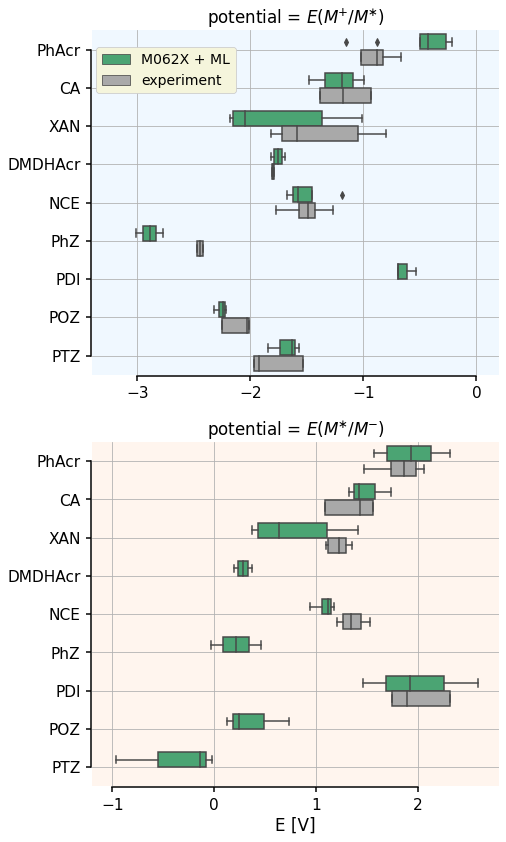

In [61]:
# M062X and M06 MAEs for the three types of approximations
plotdb_M062X = redoxranges.query("functional == 'M062X' and E00 == r'$E_{ML}$'")
plotdb_expt = redoxranges.query("functional == 'experiment'")
plotdb = plotdb_M062X.append(plotdb_expt)
plotdb.replace({"M062X":"M062X + ML"}, inplace=True)

sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.FacetGrid(plotdb, row="potential", height=6, aspect=0.9, sharex=False)
g.map_dataframe(sns.boxplot, x="E [V]", y="molecule_type", hue="functional", palette=["mediumseagreen","darkgrey"]) #palette=sns.color_palette("Dark2")
                # edgecolor="white", errwidth=1.2, capsize=.125, palette=sns.color_palette())
g.set(ylabel=None)
# bbox_to_anchor=(0.479, 0.906) for legend in non-abbreviated plots
g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, bbox_to_anchor=(0.335, 0.906), fontsize=14)

for ax in g.axes.flat:
  ax.grid(True, axis='both')
  ax.set_axisbelow(True)

g.axes.flat[0].set_xlim(-3.4,0.2)
g.axes.flat[0].set_xticks([-3,-2,-1,0])
g.axes.flat[0].set_facecolor("aliceblue")
g.axes.flat[1].set_xlim(-1.2,2.8)
g.axes.flat[1].set_xticks([-1,0,1,2])
g.axes.flat[1].set_facecolor("seashell")

# sns.despine()
sns.despine(offset=1, trim=True)
plt.tight_layout()
# plt.savefig(f'M06-adj_vs_M062X_vs_expt_boxplot.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()

<ipython-input-62-68273e7fc6a8>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


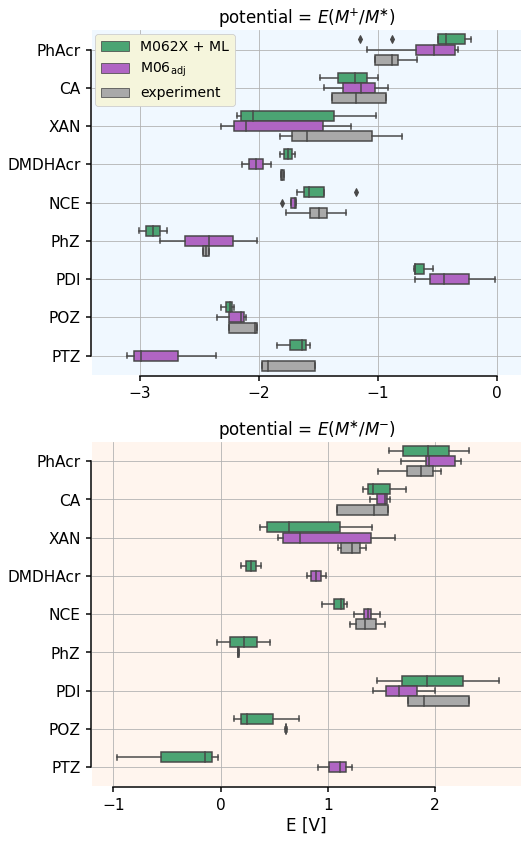

In [62]:
# M062X and M06 MAEs for the three types of approximations
plotdb_M062X = redoxranges.query("functional == 'M062X' and E00 == r'$E_{ML}$'")
plotdb_M06 = redoxranges.query("functional == r'$\mathregular{M06_{adj}}$' and E00 == r'$E_{abs,adj}$'")
plotdb_expt = redoxranges.query("functional == 'experiment'")
plotdb = plotdb_M062X.append(plotdb_M06).append(plotdb_expt)
plotdb.replace({"M062X":"M062X + ML"}, inplace=True)

sns.reset_orig()
plt.style.use("seaborn-paper")
scale=1.5
sns.set_context("paper", font_scale=1.75, rc={"lines.linewidth": scale,"axes.linewidth": 
                                               scale,'xtick.major.width': scale,'ytick.major.width': scale})

g = sns.FacetGrid(plotdb, row="potential", height=6, aspect=0.95, sharex=False)
g.map_dataframe(sns.boxplot, x="E [V]", y="molecule_type", hue="functional", palette=["mediumseagreen","mediumorchid","darkgrey"])
                # edgecolor="white", errwidth=1.2, capsize=.125, palette=sns.color_palette())
g.set(ylabel=None)
g.add_legend(frameon=True, title=None, loc='center', facecolor="beige", framealpha=1, ncol=1, bbox_to_anchor=(0.32, 0.906), fontsize=14)
# bbox_to_anchor=(0.92, 0.2635)

for ax in g.axes.flat:
  ax.grid(True, axis='both')
  ax.set_axisbelow(True)

g.axes.flat[0].set_xlim(-3.4,0.2)
g.axes.flat[0].set_xticks([-3,-2,-1,0])
g.axes.flat[0].set_facecolor("aliceblue")
g.axes.flat[1].set_xlim(-1.2,2.8)
g.axes.flat[1].set_xticks([-1,0,1,2])
g.axes.flat[1].set_facecolor("seashell")

# sns.despine()
sns.despine(offset=1, trim=True)
plt.tight_layout()
# plt.savefig(f'M06-adj_vs_M062X_vs_expt_boxplot_v2.png', dpi=200, bbox_inches='tight', pad_inches=0.05)
plt.show()
plt.close()